### Implementation of 2D U-Net
*Reference* <br/>
1. [Paper](https://arxiv.org/abs/1505.04597) <br/>
2. [Implementation](https://github.com/milesial/Pytorch-UNet)
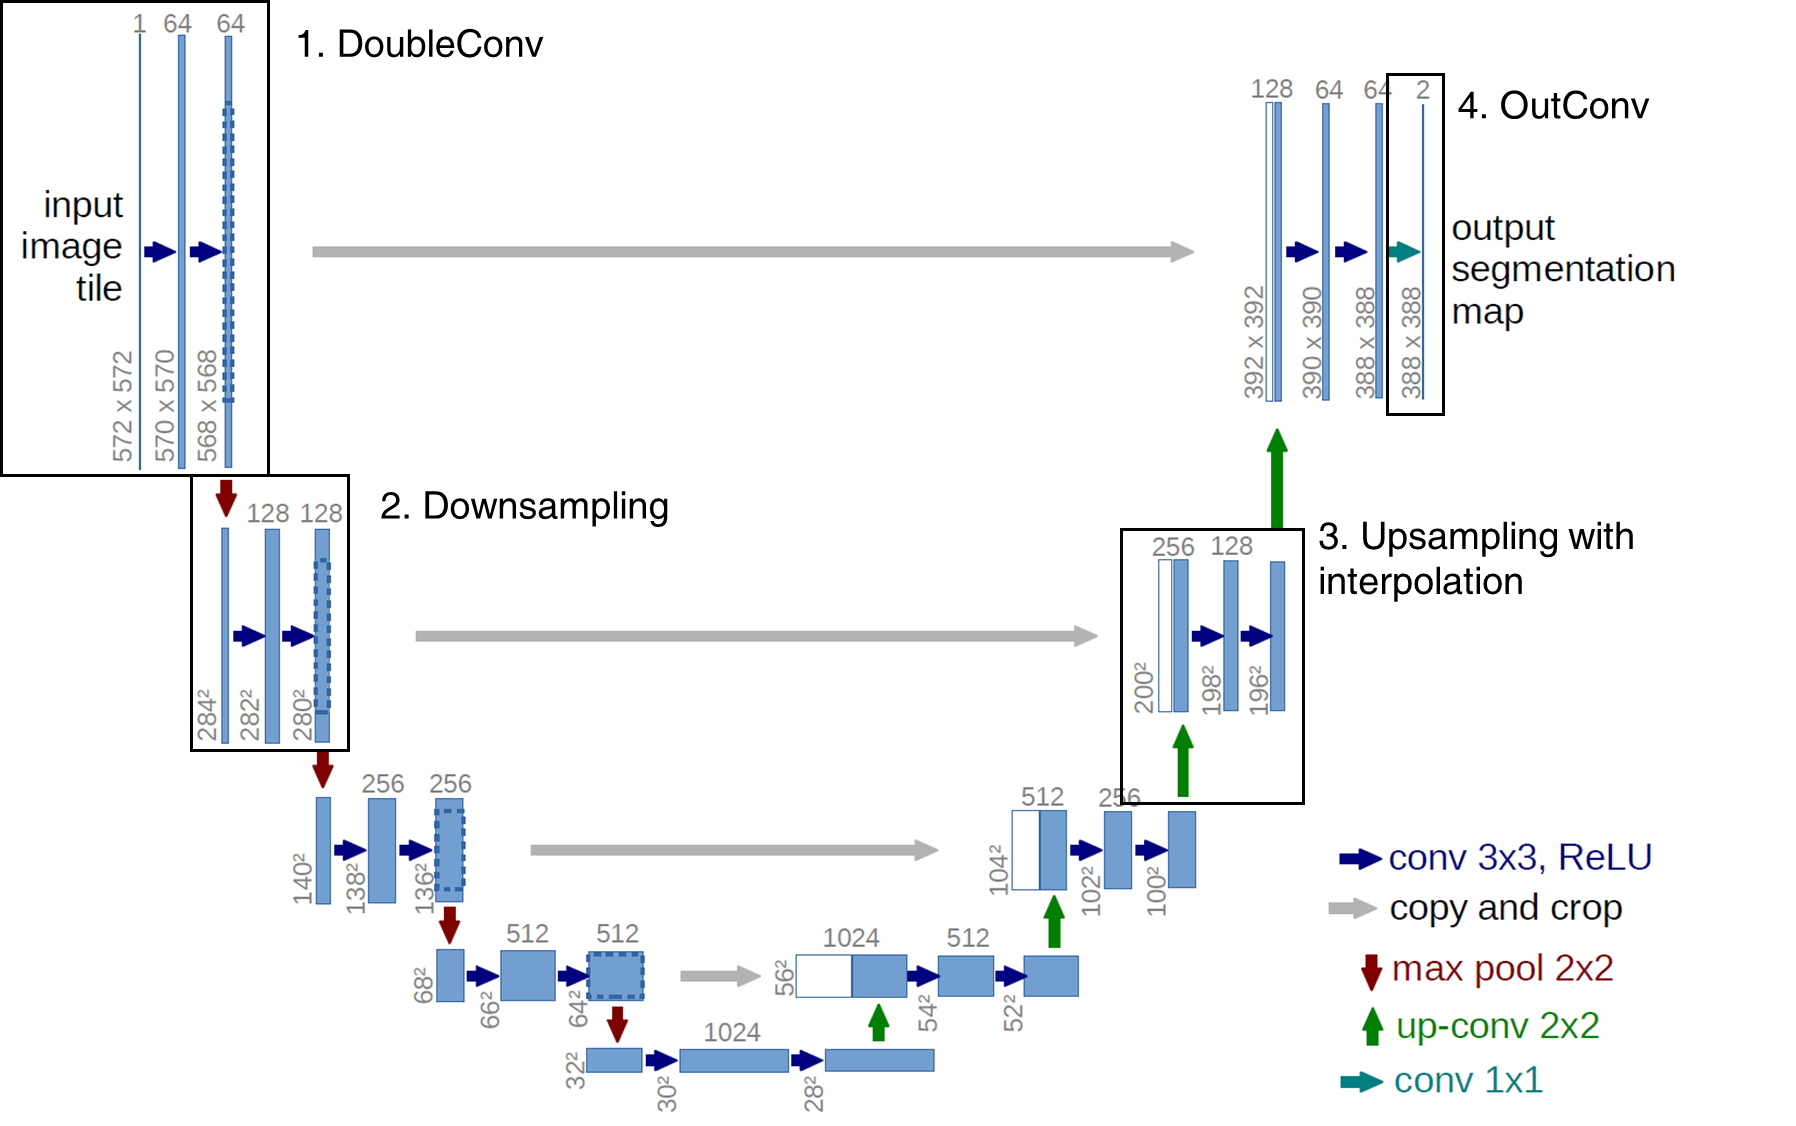

``` python
import torch
import torch.nn as nn
import torch.nn.functional as F
```
- **Key of U-Net implementation**
    1. Double-Convolution : two consecutive 3X3 convolution layer followed by ReLU
    2. Downsampling : 2X2 max-pooling
    3. Upsampling :  2x2 up-convolution
    4. Out-Convolution : Last convolution layer in U-Net (mirroring idea)

**1. Double-Convolution**

```python
class DoubleConv(nn.Module): # nn.Module inheritance
    """(3X3 convolution => [BN] => ReLU) * 2 times"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None): # in_channels, out_channels + mid_channels
        
        super().__init__() # nn.Module(parent class) -> __init__() module execution
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential( # Sequentially Stack Model
            nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1, bias = False), # padding = 1 means padding = same for 3X3 conv.
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, bias = False)
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace = True)
        )
    
    def forward(self, x):
        return self.double_conv(x)
```

**2. Downsampling**
``` python
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        
        return self.maxpool_conv(x)
```

**3. Upsampling**
- Downsampling & General Resizing -> ```nn.Interpolate()```
- Upsampling -> ```nn.Upsample()``` , ```nn.ConvTranspose2d()```
- ```nn.ConvTranspose2d()``` : element-wise sum after convolution with single elements
- ```nn.functional.pad()``` : 
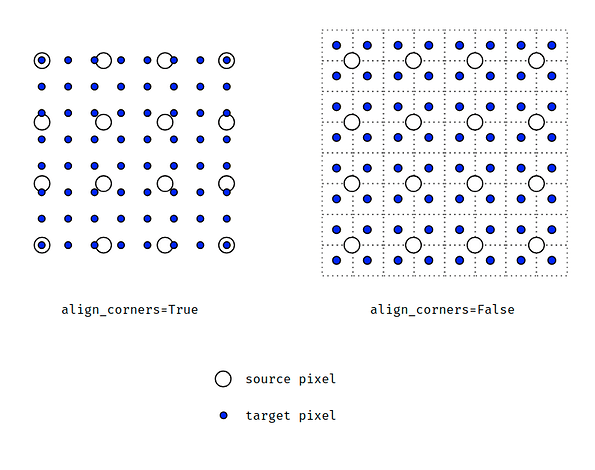
``` python
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear = True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = True) # bilinear Interpolation
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is C X H X W
        diffY = x2.size()[2] - x1.size()[2] # difference of Height
        diffX = x2.size()[3] - x1.size()[3] # difference of Width

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, # Pad with diffX, diffY in total to make size of x1, x2 same.
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1) # Direct Connections in U-Net, Channel dimension concat.
        return self.conv(x)
```

**4. OutConv**
``` python
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) # 1X1 convolution for output segmentation map

    def forward(self, x):
        return self.conv(x)
 ```

### U-Net full assembly
``` python
from .unet_parts import *

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1 # Check wheter interpolation is activated
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1) # Down
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4) # Up, U-Net with direct connections
        x = self.up2(x, x3)  
        x = self.up3(x, x2)  
        x = self.up4(x, x1) 
        logits = self.outc(x) # Output logits
        return logits
```